In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [3]:
import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [4]:
#toy example of data engineering function
def engineerData(df, engineeringParam1='defaultValue', engineeringParam2='anotherValue', isTrain=True, hasY=True):
    #...
    #do some processing of df in here.
    #as this is a toy e.g., I just return data without any changes
    newEngineeredData = df
    #...
    if hasY:
        return newEngineeredData.iloc[:,:-1], newEngineeredData.iloc[:,-1]
    else:
        return newEngineeredData

## Read-in date and take a look

In [5]:
data = pd.read_csv('./export.csv')

In [6]:
data.head()

,Unnamed: 0,Undl0volatm_6M,Undl0skew95.105_6M,Undl0curve95.105_6M,Undl0skew70.130_6M,Undl0curve70.130_6M,Undl0volatm_1Y,Undl0skew95.105_1Y,Undl0curve95.105_1Y,Undl0skew70.130_1Y,...,Undl2svc,Undl0mr,Undl1mr,Undl2mr,"ContractFeature_Autocall,BarrierLevel,LevelInitial","ContractFeature_ExpiryPayment,BarrierLevel","ContractFeature_ExpiryPayment,KickInPaymentGearing_ENCODED","ContractFeature_Schedule,EndDate_ENCODED","ContractFeature_Schedule,PeriodFrequency_ENCODED",val_lvsvcharge
0,27000,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,...,-0.51,1.32,1.27,1.065,1.0,0.50,1.0,1,4.0,0.011354
1,27001,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,...,-0.51,1.32,1.27,1.065,1.0,0.50,2.0,1,4.0,0.018649
2,27002,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,...,-0.51,1.32,1.27,1.065,1.0,0.50,1.0,1,12.0,0.014786
3,27003,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,...,-0.51,1.32,1.27,1.065,1.0,0.50,2.0,1,12.0,0.023954
4,27004,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,...,-0.51,1.32,1.27,1.065,1.0,0.55,1.0,1,4.0,0.012308


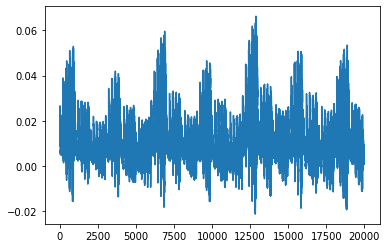

In [7]:
plt.plot(np.arange(data.shape[0]), data.iloc[:,-1])
plt.show()

We remark that target possede certain pattern, so we want to re-shuffle the input.

### Reshuffle

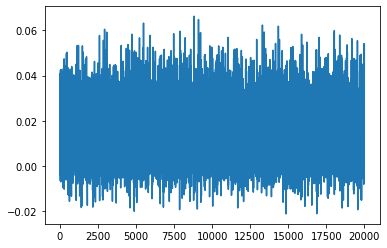

In [8]:
data = data.sample(frac = 1).reset_index(drop = True)
plt.plot(np.arange(data.shape[0]), data.iloc[:,-1])
plt.show()

## Drop unamed column
We remark that  XGBoost take user id as information, which is apparently overfitting.

In [9]:
data = data.drop('Unnamed: 0', 1)

## Grid search for xgboost parameters

In [10]:
#model parameters
# param = { 'objective':'mse','max_depth':7,'learning_rate':.01,'max_bin':250, 'seed':15, 'verbose': -1}
# param['metric'] = ['mean_squared_error']

# a parameter grid for xgboost
param = { #'objective':'mse',
         'max_depth':[7,10,4],
         'learning_rate':[.01, .005, .1],
         'max_bin':[250], 
         'max_depth':[3,5,7],
         'gamma':[0,0.5]
         #'seed':15, 
         #'verbose': -1
        }

In [11]:
#training loop
samplesize = 5000
trainValidSplit = int(0.75*samplesize)
# roundPerBatch = 50

In [12]:
engineerData(data.sample(samplesize).iloc[:trainValidSplit,:])[1]

5149     0.016101
5073     0.005247
2441    -0.008973
16433    0.016947
5189     0.009778
           ...   
18330    0.020968
6678     0.018660
382      0.011946
3551     0.017345
9432     0.007648
Name: val_lvsvcharge, Length: 3750, dtype: float64

In [13]:
# Take a sample for  hyperparameter tuning
sampleX,sampleY = engineerData(data.sample(samplesize).iloc[:trainValidSplit,:])

In [14]:
# sampleX = sampleX.drop('ContractFeature_Schedule,EndDate_ENCODED',1)
sampleX.head()

,Undl0volatm_6M,Undl0skew95.105_6M,Undl0curve95.105_6M,Undl0skew70.130_6M,Undl0curve70.130_6M,Undl0volatm_1Y,Undl0skew95.105_1Y,Undl0curve95.105_1Y,Undl0skew70.130_1Y,Undl0curve70.130_1Y,...,Undl1svc,Undl2svc,Undl0mr,Undl1mr,Undl2mr,"ContractFeature_Autocall,BarrierLevel,LevelInitial","ContractFeature_ExpiryPayment,BarrierLevel","ContractFeature_ExpiryPayment,KickInPaymentGearing_ENCODED","ContractFeature_Schedule,EndDate_ENCODED","ContractFeature_Schedule,PeriodFrequency_ENCODED"
8259,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,0.141526,...,-0.6300,-0.68,3.96,3.81,3.195,1.05,0.70,1.0,1,4.0
579,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,0.141526,...,-0.6300,-0.68,1.32,1.27,1.065,1.15,0.50,1.0,1,4.0
11146,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,0.141526,...,-0.4725,-0.51,2.64,2.54,2.130,1.05,0.55,1.0,2,12.0
16275,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,0.141526,...,-0.6300,-0.68,2.64,2.54,2.130,1.00,0.60,1.0,1,12.0
11423,0.199696,-0.639256,0.548851,-0.522159,0.271453,0.175803,-0.289374,0.207985,-0.2683,0.141526,...,-0.6300,-0.68,2.64,2.54,2.130,1.00,0.55,2.0,4,4.0


In [15]:
sampleY

8259     0.003342
579      0.005626
11146    0.021826
16275    0.011193
11423    0.024326
           ...   
9731    -0.003219
16925    0.014023
15909    0.005125
1327     0.009078
8918     0.003895
Name: val_lvsvcharge, Length: 3750, dtype: float64

In [16]:
# apply gridSearch to this sample
xgb = XGBRegressor(nthread = -1)
grid = GridSearchCV(xgb, param)
grid.fit(sampleX, sampleY)

[15:37:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0, 0.5], 'learning_rate': [0.01, 0.005, 0.1],
                         'max_bin': [2

In [17]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_bin=250,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [18]:
# best_xgb = XGBRegressor(nthread = -1, learning_rate = 0.1, max_depth = 3)
best_xgb = grid.best_estimator_

In [19]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_bin=250,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [20]:
# best_xgb = XGBRegressor(nthread = -1, learning_rate = 0.1, max_depth = 3, gamma = 0, max_bin = 300)

In [21]:
#for each batch, we'll train on 75% of data and validate with the rest.
trainValidIndex = int(0.75*len(data))
#engineer features. Here, our toy function
trainX, trainY = engineerData(data.iloc[:trainValidIndex,:])

In [22]:
trainY

0        0.016317
1        0.012242
2        0.004407
3        0.024401
4        0.002798
           ...   
14995    0.007918
14996    0.010605
14997    0.019785
14998    0.007747
14999    0.026993
Name: val_lvsvcharge, Length: 15000, dtype: float64

In [23]:
validX, validY = engineerData(data.iloc[trainValidIndex:,:], isTrain=False)
#build training and validation gbm dataset objects
# fitted = best_xgb.fit(trainX.drop('ContractFeature_Schedule,EndDate_ENCODED',1), trainY)
fitted = best_xgb.fit(trainX, trainY)

# dtrainX = best_xgb.DMatrix(data = trainX.values, feature_names = trainX.columns, label = trainY.values)

[15:39:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
predY = fitted.predict(validX)
# predY = fitted.predict(validX.drop('ContractFeature_Schedule,EndDate_ENCODED',1))

In [25]:
np.sum((predY-validY)**2/len(validY))

9.9382671860567e-07

In [26]:
best_xgb.evals_result

<bound method XGBModel.evals_result of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_bin=250,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)>

In [27]:
fitted.feature_importances_

array([0.04249409, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

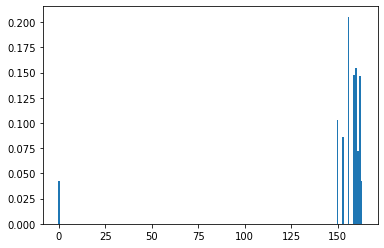

In [28]:
# plot
plt.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
plt.show()

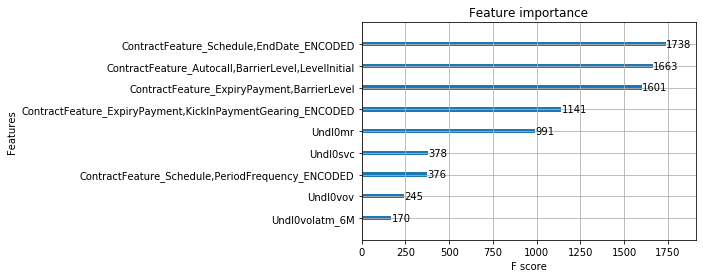

In [29]:
# plot feature importance
plot_importance(best_xgb)
plt.show()

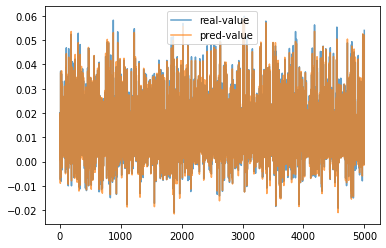

In [30]:
plt.figure()
plt.plot(np.arange(len(validX)), validY, alpha = 0.7, label = 'real-value')
plt.plot(np.arange(len(validX)), predY, alpha = 0.7, label = 'pred-value')
plt.legend()
plt.show()

## Plot intepretation


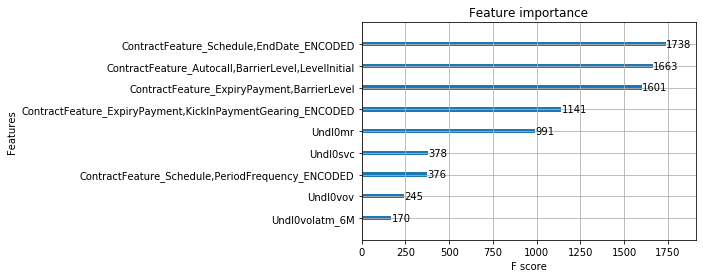

In [40]:
# # requires graphviz and python-graphviz conda packages
import graphviz
import xgboost

xgboost.plot_importance(best_xgb)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
# xgboost.to_graphviz(best_xgb, num_trees=best_xgb.best_iteration) // best_iteration ?



* https://www.kaggle.com/zj0512/using-xgboost-with-scikit-learn
example at the end of this link